# DuckDB 초기화

In [10]:
import os

DUCKDB_DB_FILE = "book_data.duckdb"

# 기존 DuckDB 데이터베이스 파일 삭제
if os.path.exists(DUCKDB_DB_FILE):
    os.remove(DUCKDB_DB_FILE)
    print(f"DuckDB 파일 '{DUCKDB_DB_FILE}' 삭제 완료.")
else:
    print(f"DuckDB 파일 '{DUCKDB_DB_FILE}'이 존재하지 않습니다. 초기화가 필요하지 않습니다.")

DuckDB 파일 'book_data.duckdb' 삭제 완료.


# Milvus 초기화

In [11]:
from pymilvus import connections, utility

MILVUS_COLLECTION_NAME = 'book_images_vectors'

try:
    # Milvus 연결
    connections.connect("default", host="localhost", port="19530")
    
    # 기존 Milvus 컬렉션 삭제
    if utility.has_collection(MILVUS_COLLECTION_NAME):
        utility.drop_collection(MILVUS_COLLECTION_NAME)
        print(f"Milvus 컬렉션 '{MILVUS_COLLECTION_NAME}' 삭제 완료.")
    else:
        print(f"Milvus 컬렉션 '{MILVUS_COLLECTION_NAME}'이 존재하지 않습니다. 초기화가 필요하지 않습니다.")
    
except Exception as e:
    print(f"Milvus 연결 또는 초기화 중 오류 발생: {e}")

Milvus 컬렉션 'book_images_vectors' 삭제 완료.


# DuckDB 데이터 확인

In [14]:
import duckdb

DUCKDB_DB_FILE = "book_data.duckdb"

try:
    con = duckdb.connect(database=DUCKDB_DB_FILE, read_only=True)
    
    # 1. 'book_metadata' 테이블의 모든 행 수 계산
    count_result = con.execute("SELECT COUNT(*) FROM book_metadata").fetchone()
    if count_result and count_result[0] > 0:
        print(f"DuckDB에 저장된 데이터 개수: {count_result[0]}개")
    else:
        print("DuckDB에 데이터가 없거나 테이블을 찾을 수 없습니다.")

    # 2. 데이터 샘플 5개 조회 (선택 사항)
    sample_data = con.execute("SELECT * FROM book_metadata LIMIT 5").df()
    print("\n--- DuckDB 데이터 샘플 ---")
    print(sample_data)

    con.close()

except Exception as e:
    print(f"DuckDB 데이터 확인 중 오류 발생: {e}")

DuckDB에 저장된 데이터 개수: 1000개

--- DuckDB 데이터 샘플 ---
                 id                                              title  \
0  90fa61229261140a                                 Tipping the Velvet   
1  6957f44c3847a760                                         Soumission   
2  a897fe39b1053632                               A Light in the Attic   
3  e72a5dfc7e9267b2  The Coming Woman: A Novel Based on the Life of...   
4  4165285e1663650f              Sapiens: A Brief History of Humankind   

                upc      price  \
0  90fa61229261140a  53.740002   
1  6957f44c3847a760  50.099998   
2  a897fe39b1053632  51.770000   
3  e72a5dfc7e9267b2  17.930000   
4  4165285e1663650f  54.230000   

                                                 url  \
0  http://books.toscrape.com/catalogue/tipping-th...   
1  http://books.toscrape.com/catalogue/soumission...   
2  http://books.toscrape.com/catalogue/a-light-in...   
3  http://books.toscrape.com/catalogue/the-coming...   
4  http://books.toscr

# Milvus 데이터 확인

In [15]:
from pymilvus import connections, Collection

MILVUS_COLLECTION_NAME = 'book_images_vectors'

try:
    # 1. Milvus 연결
    connections.connect("default", host="localhost", port="19530")
    
    # 2. 컬렉션 객체 가져오기
    collection = Collection(MILVUS_COLLECTION_NAME)
    
    # 3. 컬렉션에 저장된 엔티티 총 개수 확인
    milvus_count = collection.num_entities
    if milvus_count > 0:
        print(f"Milvus에 저장된 엔티티(벡터) 개수: {milvus_count}개")
    else:
        print("Milvus에 엔티티가 없거나 컬렉션을 찾을 수 없습니다.")

    # 4. 컬렉션 속성 출력 (선택 사항)
    print("\n--- Milvus 컬렉션 정보 ---")
    print("컬렉션 이름:", collection.name)
    print("스키마:", collection.schema)
    
except Exception as e:
    print(f"Milvus 데이터 확인 중 오류 발생: {e}")

Milvus에 저장된 엔티티(벡터) 개수: 1000개

--- Milvus 컬렉션 정보 ---
컬렉션 이름: book_images_vectors
스키마: {'auto_id': False, 'description': '책 이미지 벡터와 UPC', 'fields': [{'name': 'id', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 128}, 'is_primary': True, 'auto_id': False}, {'name': 'vector', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 512}}], 'enable_dynamic_field': False}


# DuckDB와 Milvus를 활용한 이미지 추출

--- Milvus에서 가져온 단일 엔티티 정보 ---
UPC: 759ee7d059b1beb8
벡터(일부): [0.07439200580120087, 0.0022076324094086885, 0.01910620927810669, -0.050763264298439026, -0.05394409969449043] ... (총 512 차원)
✅ Milvus 데이터 확인 완료.

--- DuckDB에서 가져온 상세 메타데이터 ---
제목: Why Save the Bankers?: And Other Essays on Our Economic and Political Crisis
가격: 48.66999816894531
이미지 경로: data/images/759ee7d059b1beb8.jpg


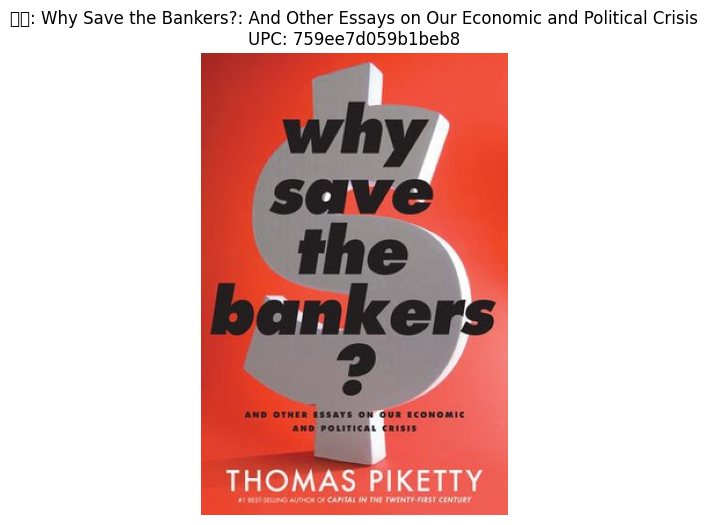

✅ 이미지 시각화 완료.


In [18]:
import os
import duckdb
import matplotlib.pyplot as plt
from pymilvus import connections, Collection, utility
from PIL import Image

MILVUS_COLLECTION_NAME = 'book_images_vectors'
DUCKDB_DB_FILE = 'book_data.duckdb'

def visualize_random_data():
    try:
        # 1. DuckDB 연결 및 데이터 확인
        con = duckdb.connect(database=DUCKDB_DB_FILE, read_only=True)
        
        # 2. DuckDB에서 무작위로 데이터 1개 추출
        # `USING SAMPLE` 구문을 사용하여 무작위로 1개 행을 추출합니다.
        query = "SELECT * FROM book_metadata USING SAMPLE 1;"
        duckdb_result = con.execute(query).fetchone()

        if not duckdb_result:
            print("❌ DuckDB에서 데이터를 가져오지 못했습니다. ETL을 먼저 실행하세요.")
            con.close()
            return
            
        columns = [desc[0] for desc in con.description]
        duckdb_data = dict(zip(columns, duckdb_result))
        upc = duckdb_data.get('upc')
        con.close()

        # 3. Milvus 연결 (선택 사항: Milvus 데이터 확인용)
        # DuckDB에서 가져온 UPC를 사용하여 Milvus에서 벡터 정보를 확인합니다.
        try:
            connections.connect("default", host="localhost", port="19530")
            collection = Collection(MILVUS_COLLECTION_NAME)
            collection.load()
            
            # Milvus에서 UPC(id)로 벡터 조회
            milvus_results = collection.query(
                expr=f"id == '{upc}'",
                output_fields=["vector"],
                limit=1
            )
            
            if milvus_results:
                milvus_vector = milvus_results[0]['vector']
                print("--- Milvus에서 가져온 단일 엔티티 정보 ---")
                print(f"UPC: {upc}")
                print(f"벡터(일부): {milvus_vector[:5]} ... (총 {len(milvus_vector)} 차원)")
                print("✅ Milvus 데이터 확인 완료.")
            else:
                print(f"❌ Milvus에서 UPC '{upc}'에 대한 벡터를 찾을 수 없습니다.")

        except Exception as e:
            print(f"❌ Milvus 데이터 확인 중 오류 발생: {e}")
        
        # 4. 상세 메타데이터 출력 및 이미지 시각화
        print("\n--- DuckDB에서 가져온 상세 메타데이터 ---")
        print(f"제목: {duckdb_data.get('title')}")
        print(f"가격: {duckdb_data.get('price')}")
        print(f"이미지 경로: {duckdb_data.get('image_path')}")
        
        image_path = duckdb_data.get('image_path')
        if image_path and os.path.exists(image_path):
            try:
                img = Image.open(image_path)
                fig, ax = plt.subplots(figsize=(6, 6))
                ax.imshow(img)
                ax.set_title(f"제목: {duckdb_data.get('title')}\nUPC: {upc}")
                ax.axis('off')
                plt.show()
                print("✅ 이미지 시각화 완료.")
            except Exception as e:
                print(f"❌ 이미지 시각화 중 오류 발생: {e}")
        else:
            print(f"❌ 이미지 파일이 없거나 경로가 올바르지 않습니다: {image_path}")

    except Exception as e:
        print(f"DuckDB 연결 또는 데이터 확인 중 오류 발생: {e}")

if __name__ == '__main__':
    visualize_random_data()